## Comic Book Covers
### Image & Metadata Exploratory Analysis

This notebook contains an exploratory data analysis of comic book images and metadata scraped from https://comics.org. 

The methods created for this analysis come w/ tests and docstrings that can be found in the `comics_net.webscraper` and `comics_net.analyzer` modules.

In [1]:
import math
import operator
import os
import random
import re
from functools import reduce

import jsonlines
import numpy as np
import pandas as pd
from IPython.display import clear_output, display
from pandas import DataFrame
from PIL import Image

from comics_net import analyzer
from comics_net.character_map import aliases
from comics_net.webscraper import strip_brackets

In [2]:
# load the metadata
df = analyzer.load_metadata('../metadata/covers.jsonl')

# parse issue number and cast as int
df['issue_number'] = df['title'].apply(analyzer.get_issue_number_from_title)

# describe categorical metadata features
df.drop(['issue_number', 'covers'], axis=1).describe().T

,count,unique,top,freq
format_binding,95364,185,Saddle-stitched,36304
format_color,95364,117,Color,47425
format_dimensions,95364,395,standard Modern Age US,18403
format_paper_stock,95364,329,,23219
format_publishing_format,95364,149,was ongoing series,34284
indexer_notes,95364,53594,,23530
indicia_frequency,95364,2031,monthly,35222
issue_brand,95364,387,DC [bullet],12958
issue_indicia_publisher,95364,206,DC Comics,18521
issue_pages,95364,326,36,61558


Above we show the sumamry statistics of the issue metadata for the comic books scraped thus far. 

This summary only contains the _issue_ metadata and does not include the _cover_ metadata, which is specific to the image of the comic book cover. Because there are variant covers this information is stored as `dicts` in the "covers" field.

## Unpack Covers & Parse Character Labels

Since some issues contain variant covers drawn by different artists and containing different characters on them, each comic book contains issue metadata and cover-image metadata

Below we unpack the covers metadata and parse the list of characters appearing on each cover (and variant).

In [3]:
# create cover df
covers_dict = df["covers"].to_dict()

# add dataframe index to cover image-level metadata
for d1 in covers_dict:
    for d2 in covers_dict[d1]:
        covers_dict[d1][d2]["index"] = d1
        
# unpack cover image-level metadata
df_covers = pd.concat([pd.DataFrame(x).T for x in covers_dict.values()], axis=0)

# join cover-image-level metadata back with issues metadata
df = pd.merge(df.reset_index(),
              df_covers,
              how='outer',
              on='index').\
    sort_values(["series_name", "issue_number"], ascending=True).\
    drop(["index", "covers"], axis=1).\
    reset_index(drop=True).\
    copy()

# convert cover_characters string to list
def map_convert_characters_to_list(characters: str):
    if characters is np.nan:
        return np.nan
    else:
        return analyzer.convert_characters_to_list(characters)

# listify character string
df["cover_characters_list"] = df["cover_characters"].apply(map_convert_characters_to_list)

## Pre-process Character Labels

The comic book cover cover images and character label data scraped from https://comics.org may contain slight variations in a character label, for example, Superman may be labeled as:
```
[
"Superman [Clark Kent/ Kal-El]",
"Superman [Clark Kent]"
"Superman [Kal-El]"
"Superman (Earth-1)"
"Superman (of Earth-1)"
"Superman (Earth One)"
"Superman (Earth-2)"
"Superman (of Earth-2)"
"Superman [Kal Kent/ Kal-El]"
]
```
But for the classification and style transfer tasks we will perform, these labels are equivalent and should be treated as one class.

In [4]:
# convert cover_characters string to list
def map_aliases(characters_list: str):
    if characters_list is np.nan:
        return np.nan
    else:
        return [aliases.get(character, character) for character in characters_list]
    
# apply aliases to character names
df["cover_characters_list_aliases"] = df["cover_characters_list"].apply(lambda x: map_aliases(x))

# drop interim calc. fields
df = df.drop("cover_characters_list", axis=1)

# where synopisis is blank, replace w/ NaN
df.loc[df["synopsis"] == "", "synopsis"] = np.nan

# describe issue and cover metadata
df.drop(['issue_number', 'cover_characters_list_aliases'], axis=1).describe().T

,count,unique,top,freq
format_binding,112469,185,Saddle-stitched,45209
format_color,112469,117,Color,58760
format_dimensions,112469,395,Standard Modern Age US,22635
format_paper_stock,112469,329,,28074
format_publishing_format,112469,149,was ongoing series,37220
indexer_notes,112469,53594,,23530
indicia_frequency,112469,2031,monthly,40435
issue_brand,112469,387,Marvel [white on red],15774
issue_indicia_publisher,112469,206,DC Comics,21643
issue_pages,112469,326,36,68876


In [5]:
# remove "cameo", "headshot"/"head shot"/"head only", "villain", "clone", "young", "vignette", "silhouette", "young", (Earth-1), (Earth-2) from character name???
# filter out "inset", "hand only"/"only hand", "photo" character names???

# explore distribution of substrings in character names
all_characters = analyzer.flatten(df["cover_characters_list_aliases"].dropna().values)

pd.Series([x for x in all_characters if "inset" in x.lower()]).value_counts()[:10]

The Flash [Jay Garrick] (inset)       48
The Hawkman [Carter Hall] (inset)     48
Starman [Ted Knight] (inset)          27
Huntress [Helena Wayne] (inset)       23
Green Lantern [Hal Jordan] (inset)    18
Green Lantern [Alan Scott] (inset)    16
Starman (inset)                       16
The Atom [Ray Palmer] (inset)         14
Batman [Bruce Wayne] (inset)          14
Robin [Dick Grayson] (inset)          14
dtype: int64

### Analyze Team Frequency and Make-up

Many comic book characters are part of a larger team and co-occur frequently with their teammates.

In [6]:
# TODO: refactor/combine this with `map_convert_characters_to_list" method in analyzer module

def map_convert_characters_to_team_list(characters: str):
    """
    Given a character string return the parsed list of unique characters.
    """
    t = analyzer.replace_semicolons_in_brackets(characters)

    stack = 0
    startIndex = None
    results = []

    # TODOL: pull this out into it's own function
    matches = []
    for i, c in enumerate(t):
        if c == "[":
            if stack == 0:
                startIndex = i + 1  # string to extract starts one index later

            # push to stack
            stack += 1
        elif c == "]":
            # pop stack
            stack -= 1

            if stack == 0:
                matches.append((startIndex, i))
                results.append(t[startIndex:i])

    character_dict: dict = {}
    character_dict["Teams"] = {}
    character_dict["Individuals"] = {}

    for span in matches:
        entity = t[span[0] : span[1]]
        if entity.count(";") == 0:
            person_name = analyzer.look_behind(t, span[0])
            # apply aliases to character names
            person_identity = map_aliases(entity)
            character_dict["Individuals"][person_name] = person_identity

        elif entity.count(";") > 1:
            team_name = analyzer.look_behind(t, span[0])
            if team_name[:3].lower() == "the":
                team_name = team_name[3:].strip()
            team_members = list(filter(lambda x: x != "", entity.split("; ")))
            character_dict["Teams"][team_name] = map_aliases(team_members)

    team_string = analyzer.convert_character_dict_to_str(character_dict)
    remainder = analyzer.diff_strings(team_string, t)
    remainder = list(filter(lambda x: x != "", remainder.split("; ")))
    character_dict["Individuals"] = map_aliases(remainder)
    return character_dict

teams = df["cover_characters"].dropna().apply(map_convert_characters_to_team_list)
team_list = [x["Teams"] for x in teams if x["Teams"] != {}]

team_counts = pd.Series(analyzer.flatten([x.keys() for x in team_list])).value_counts()
team_counts[:20]

Avengers                      1018
Fantastic Four                 828
X-Men                          611
Justice League of America      404
Legion of Super-Heroes         346
Teen Titans                    304
Defenders                      234
Justice Society of America     208
Justice League                 187
Guardians of the Galaxy        134
X-Factor                       119
Alpha Flight                   118
Invaders                       112
Outsiders                      108
Suicide Squad                   92
Inhumans                        89
Doom Patrol                     79
Green Lantern Corps             76
Archies                         75
Excalibur                       71
dtype: int64

In [7]:
# team_name = "Power Pack"
# test = analyzer.flatten([x.get(team_name) for x in team_list if team_name in x.keys()])
# pd.Series(collapse_characters(test)).value_counts()

In [8]:
# TODO: document what this does,  if we need it?

# df_brackets = df["cover_characters"].apply(lambda x: analyzer.match_brackets(str(x)))

# df_brackets_unique = pd.Series(analyzer.flatten([list(x.keys()) for x in df_brackets if x != {}])).value_counts().index

# df_brackets_unique
# [x for x in df_brackets_unique if ";" in x]

### Remove Black & White Covers

In [9]:
is_black_and_white = pd.Series(["black and white" in x for x in df["save_to"].apply(lambda x: x.lower())])
is_black_white = pd.Series(["black & white" in x for x in df["save_to"].apply(lambda x: x.lower())])
is_blank = pd.Series(["blank cover" in x for x in df["save_to"].apply(lambda x: x.lower())])
is_sketch = pd.Series(["sketch cover" in x for x in df["save_to"].apply(lambda x: x.lower())])
is_wraparound = pd.Series(["wraparound" in x for x in df["save_to"].apply(lambda x: x.lower())])
is_200_incentive = pd.Series(["1:200 incentive" in x for x in df["save_to"].apply(lambda x: x.lower())])
is_lenticular = pd.Series(["lenticular" in x for x in df["save_to"].apply(lambda x: x.lower())])
is_nonlenticular = pd.Series(["non-lenticular" in x for x in df["save_to"].apply(lambda x: x.lower())])
is_sketch_exclusive = pd.Series(["sketch exclusive" in x for x in df["save_to"].apply(lambda x: x.lower())])
is_photo = pd.Series(["photo cover" in x for x in df["save_to"].apply(lambda x: x.lower())])

df = df.loc[~(is_black_and_white 
              | is_black_white 
              | is_blank 
              | is_sketch 
              | is_wraparound 
              | is_200_incentive 
              | (is_lenticular & ~is_nonlenticular) 
              | is_sketch_exclusive
              | is_photo), ]

### Analyze Distribution of Cover Image Resolution

In [10]:
# covers = df["save_to"]

# cover_dims = {}
# for cover in covers:
#     im = Image.open('.' + cover)
#     cover_dims[cover] = im.size

# covers = pd.DataFrame.from_dict(cover_dims).T.reset_index()
# covers.columns = ["save_to", "cover_width", "cover_height"]

# "Calculated dims for {} covers".format(len(cover_dims.keys()))

In [11]:
# dims = [(x, y) for x, y in zip(covers["cover_width"], covers["cover_height"])]

# n = 100
# pct = pd.Series(pd.Series(dims).value_counts() / len(dims)).cumsum()[:n].tail(1).values[0] * 100
# print('Top {} image sizes account for {}% of covers'.format(n, round(pct, 1)), '\n')

# top_dims = pd.Series(pd.Series(dims).value_counts() / len(dims)).cumsum()[:n].index
# top_dims

# print('Top Image Sizes:')
# print(top_dims.values, '\n')
# print('Height distribution:')
# pd.Series(covers[covers["cover_width"] == 400]["cover_height"]).describe()

### Filter Non-Standard Sizes

In [12]:
# median_resolution = (400, 613)  # to use when resizing

In [13]:
# df = pd.merge(df, covers, on="save_to", how="left")
# df = df[df["cover_width"] == 400].reset_index(drop=True)

### Clean Artist Names

In [14]:
# remove brackets from artists name, listify multiple artists, additional cleanup, etc...
def clean_cover_pencils(pencils: str):
    if pencils is np.nan:
        return np.nan
    else:
        return pencils.\
    replace("(signed)", "").\
    replace("(sketch)", "").\
    replace("(credited)", "").\
    replace("(painted)", "").\
    replace("(painting)", "").\
    replace("(credited, signed)", "").\
    replace("(signed, credited)", "").\
    replace("[as GK]", "").\
    strip()
    
df["cover_pencils_cleaned"] = df["cover_pencils"].apply(clean_cover_pencils)
df["cover_inks_cleaned"] = df["cover_inks"].apply(clean_cover_pencils)
df["cover_colors_cleaned"] = df["cover_colors"].apply(clean_cover_pencils)

## Remove Redundant Cover Images

Programmatically navigating through deeply linked webpages and scraping assets from a specific site is an imperfect science. Website design changes, pages update, and there are edge cases galore! I did my best to handle edge cases as they occurred but under certain conditions the webscraper pulls down duplicate cover images.

For example, if an issue has variant covers such as "British" and "Original" or "Direct Sales" and "DC Universe", we may pull  down both. In this case, the cover image is almost identical except for the inset in the barcode area - so technically they are _true_ variants, but it's not a useful distinction for us, so we need to remove them.

#### Parse Base Title from Variant Title Descriptions

In [15]:
#  parse variant description from title
df["title_variant"] = df["title"].apply(lambda  x: " ".join([x.replace("[", "").replace("]", "") for x in analyzer.match_brackets(x).keys()]))

# parse base description from title
temp = df["title"].apply(lambda  x: [v["start"] for k, v in analyzer.match_brackets(x).items()]).values
df["title_base"] = [t[0][:t[1]].replace("[", "").replace("]", "").strip() for t in list(zip(df["title"], [x[0] if len(x) > 0 else 0 for x in temp]))]

# update base title where no variant
df.loc[df["title_base"]=="", "title_base"] = df.loc[df["title_base"]=="", "title"]

# count instances of base title descriptions
title_base_counts = df["title_base"].value_counts().reset_index()
title_base_counts.columns = ["title_base", "title_base_count"]

# merge count of base titles
df = pd.merge(df, title_base_counts, how="left", on="title_base").sort_values("title_base_count", ascending=False)

What we've done is parse the _base_ and _variant_ names from the "title" field and counted of the number of _base_ titles. This gives us a foundation to reason about variants and begin the process of deduping .

In [16]:
df[["title", "title_base", "title_variant", "title_base_count"]].head()

,title,title_base,title_variant,title_base_count
4952,Amazing Spider-Man #1 [Comic Sketch Art Exclus...,Amazing Spider-Man #1,Comic Sketch Art Exclusive Adam Hughes,184
4773,Amazing Spider-Man #1,Amazing Spider-Man #1,,184
4846,Amazing Spider-Man #1 [2018 San Diego Comic Co...,Amazing Spider-Man #1,2018 San Diego Comic Con International Exclusi...,184
4845,Amazing Spider-Man #1 [2018 San Diego Comic Co...,Amazing Spider-Man #1,2018 San Diego Comic Con International Exclusi...,184
4844,Amazing Spider-Man #1 [2018 San Diego Comic Co...,Amazing Spider-Man #1,2018 San Diego Comic Con International Exclusi...,184


If the number of _base_ titles is greater than 1, there may be 1) a dupe, 2) a variant, or 3) a re-numbering of the series. These are the cases we need to handle while deduping, and we only want to remove instances of a dupe while keeping any variants or re-numberings.

If the number of _base_ titles is 1, then we can rest assured there is no dupe.

#### Filter for Non-Variants

In [17]:
# filter for only those issues not having variants / dupes
df_non_variants = df[(df["title_base_count"] == 1)].sort_values(["title", "issue_number"])

#### Filter for Variants (and Possible Dupes)

Any issue containing more than 1 instance of base title is considered a variant or possible dupe.

In [18]:
# filter for only those issues having variants / dupes
df_variants = df[df["title_base_count"] > 1].sort_values(["title", "issue_number"])

"Of {} total covers, {} are either variants or redundant and {} are unique".format(len(df_variants) + len(df_non_variants), len(df_variants), len(df_non_variants))

'Of 111364 total covers, 37919 are either variants or redundant and 73445 are unique'

Grouping `df_variants` by `title_base` and `cover_pencils`, we can find which issue variants where there is more than one artist per issue. If there is more than one artist we assume it is a true variant and not a duplicate cover image.

#### Filter for True Variants

In [19]:
# count pencil artists by base title
df_variants_artists = df_variants.groupby(["title_base", "cover_pencils_cleaned"]).apply(len).reset_index()
df_variants_artists.columns = ["title_base", "cover_pencils_cleaned", "base_pencils_count"]

# merge count of pencil artists by base title with df
df_variants = pd.merge(df_variants, df_variants_artists, how="left", on=["title_base", "cover_pencils_cleaned"])

# if the base title / pencil artist combination equals 1, it's a true variant and not dupe
non_dupes = df_variants[df_variants["base_pencils_count"] == 1.0].drop("base_pencils_count", axis=1)

# concat non-dupes with non-variants
df_non_dupes = pd.concat([df_non_variants, non_dupes], axis=0)

"{} covers have been identified as non-dupes".format(len(df_non_dupes))

'92626 covers have been identified as non-dupes'

#### Filter for Possible Dupes

In [20]:
possible_dupes = df_variants[df_variants["base_pencils_count"] > 1.0].drop("base_pencils_count", axis=1)

"{} covers have been identified as possible dupes".format(len(possible_dupes))

'16896 covers have been identified as possible dupes'

#### Find True Dupes

In [21]:
def image_likeness(path_a: str,  path_b: str):
    h1 = Image.open('.' + path_a).convert('L').resize((400, 613)).histogram()
    h2 = Image.open('.' + path_b).convert('L').resize((400, 613)).histogram()

    return round(math.sqrt(reduce(operator.add, map(lambda a,b: (a-b)**2, h1, h2))/len(h1)), 2)

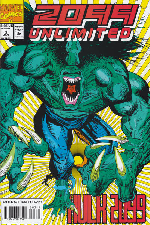

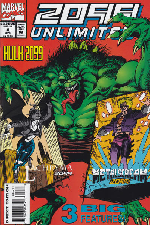

Image similarity of ./covers/2099 Unlimited: 2099 Unlimited #3 Direct Edition ().jpg and ./covers/2099 Unlimited: 2099 Unlimited #4 Direct Edition ().jpg is 609.56


In [22]:
path_a = df_non_dupes.reset_index()["save_to"][10]
path_b = df_non_dupes.reset_index()["save_to"][11]

display(Image.open('.' + path_a).resize((150, 225)), Image.open('.' + path_b).resize((150, 225)))

print("Image similarity of {} and {} is {}".format(path_a, path_b, image_likeness(path_a,  path_b)))

In [23]:
# remove redundant files from possible_dupes  (for some reason, some are counted more than once)
# TODO: find where these dupes are coming from!!!!
possible_dupes = possible_dupes.loc[possible_dupes.astype(str).drop_duplicates().index]

In [24]:
# %%timeit
n = len(possible_dupes['title_base'].unique())

counter = 0
likeness = {}
for title in possible_dupes["title_base"].unique():
    clear_output()
    counter += 1
    print("{} - {} of {}".format(title, counter, n))
    likeness[title] = {}
    tf = possible_dupes[possible_dupes["title_base"] == title].reset_index(drop=True)["save_to"]
    if len(tf) == 1:
        img = tf.loc[0]
        likeness[title][img] = {}
        likeness[title][img]["similarity"] = np.nan
    else:
        for i in range(0, len(tf)):
            if i == len(tf)-1:
                pass
            else:
                img = tf.loc[i]
                likeness[title][img] = {}
                likeness[title][img]["similarity"] = min([image_likeness(img, x) for x in tf.loc[i+1:]])

newuniversal #1 - 5785 of 5785


In [25]:
similarity = []
for k in likeness:
    try:
        similarity.append([(k, list(v.values())[0]) for k,v in likeness[k].items()])
    except:
        pass
    
dupes = pd.DataFrame(analyzer.flatten(similarity), 
                     columns=["save_to", "within_series_likeness"]).\
    sort_values("within_series_likeness").\
    reset_index(drop=True)

# merge possible dupes and dupes
possible_dupes = pd.merge(possible_dupes, dupes, on="save_to", how="left")

1
2001, A Space Odyssey #10 



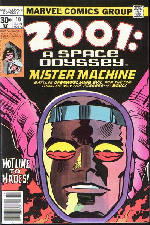

0 = 620.67
discard


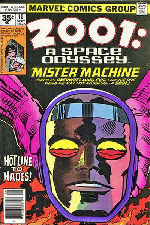

1 = 653.49
discard


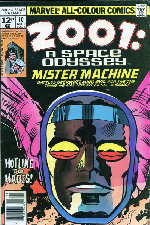

2 = nan
keep


In [26]:
idx=0
idx+=1
thingy = possible_dupes["title_base"].unique()[idx]

temp = possible_dupes[(possible_dupes["title_base"] == thingy)][["save_to", "within_series_likeness"]]
temp

print(idx)
print(thingy, '\n')
for i in range(0, len(temp)):
    path = temp["save_to"].iloc[i]
    display(Image.open('.' + path).resize((150, 225)))
    print("{} = {}".format(i, temp["within_series_likeness"].iloc[i]))
    if temp["within_series_likeness"].iloc[i] is np.nan:
        print("keep")
    elif temp["within_series_likeness"].iloc[i] <= 700:
        print("discard")
    else:
        print("keep")

### Filter Out Dupes & Combine w/ `df_non_dupes`

In [27]:
# rules to apply when deduping possible dupes
# 1) always include within likeness == 'nan'
# 2) exclude where likeness <= 500

is_null = possible_dupes["within_series_likeness"].isnull()
not_similar = possible_dupes["within_series_likeness"] > 700

keep = possible_dupes[(is_null | not_similar)]
df_non_dupes = pd.concat([df_non_dupes, keep[df_non_dupes.columns]], axis=0)

In [28]:
"{} covers have been identified as suitable for our machine learning tasks".format(len(df_non_dupes))

'104913 covers have been identified as suitable for our machine learning tasks'

### Show a random comic book cover

Pencils: Dan DeCarlo ?, Colors: ?, Colors: ? 

Characters: ['Waldo Weatherbee', 'Archie Andrews', 'Miss Phelps', 'Betty Cooper', 'Jughead Jones'] 

Synopsis: Mr. Weatherbee tells Archie that it's his birthday but he should keep it to himself. | Mr. Weatherbee reads a book that says an instructor must help a student instill confidence in himself and he tries it with Archie. | Mr. Weatherbee's car breaks down but he pretends that it hasn't when Archie and Jughead pull over to help him. | Mr. Weatherbee sprains his ankle after Archie runs into him. | Mr. Weatherbee tries to put on a safety contest. | Mr. Weatherbee puts Archie's picture on his fridge to lose weight. 



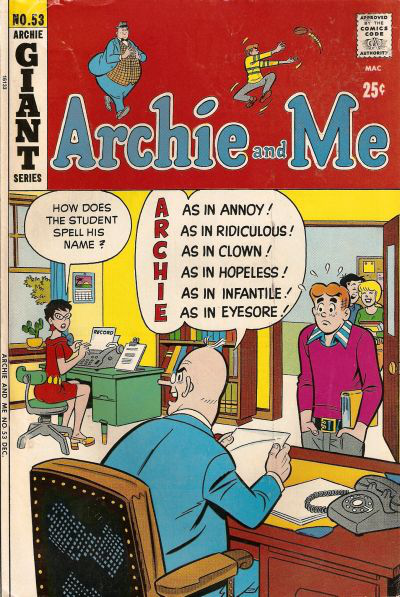

In [29]:
def get_random_sample_of_covers(df: DataFrame, character: str, n: int) -> dict:
    """
    Given a DataFrame of covers (TODO: specify that schema) and a character return a
    dict (TODO: specify that schema) of n randomly sampled covers for that character.
    """
    df = df[df["cover_characters_list_aliases"].apply(lambda x: character in x)].reset_index(drop=True)

    s = list(range(0, max(df.index)))
    random.shuffle(s)

    covers: dict = dict()
    for i in s[:n]:
        covers["cover_{}".format(i)] = {}
        covers["cover_{}".format(i)]["synopsis"] = df["synopsis"].iloc[i]
        covers["cover_{}".format(i)]["image_path"] = df["save_to"].iloc[i]
        covers["cover_{}".format(i)]["cover_inks"] = df["cover_inks"].iloc[i]
        covers["cover_{}".format(i)]["cover_colors"] = df["cover_colors"].iloc[i]
        covers["cover_{}".format(i)]["cover_pencils"] = df["cover_pencils_cleaned"].iloc[i]
        covers["cover_{}".format(i)]["characters"] = df["cover_characters_list_aliases"].iloc[i]

    return covers

random_cover = get_random_sample_of_covers(df_non_dupes[df_non_dupes["cover_characters_list_aliases"].notnull()], 
                                                    character="Archie Andrews", 
                                                    n=1)

synopsis = random_cover[list(random_cover.keys())[0]]["synopsis"]
cover_pencils = random_cover[list(random_cover.keys())[0]]["cover_pencils"]
cover_inks = random_cover[list(random_cover.keys())[0]]["cover_inks"]
cover_colors = random_cover[list(random_cover.keys())[0]]["cover_colors"]
characters = random_cover[list(random_cover.keys())[0]]["characters"]


print("Pencils: {}, Colors: {}, Colors: {}".format(cover_pencils, cover_inks, cover_colors), '\n')

print("Characters: {}".format(characters), '\n')
print("Synopsis: {}".format(synopsis), '\n')

image_path = random_cover[list(random_cover.keys())[0]]["image_path"]
im = Image.open("." + image_path)
im

### Filter for Specific Characters

In [30]:
unique_characters = pd.Series(analyzer.flatten(df_non_dupes["cover_characters_list_aliases"].dropna().values)).value_counts()
unique_characters.iloc[:50]

Batman [Bruce Wayne]                     4939
Archie Andrews                           4352
Superman [Clark Kent/ Kal-El]            4062
Betty Cooper                             3618
Spider-Man [Peter Parker]                3473
Veronica Lodge                           3373
Jughead Jones                            2387
Wolverine [Logan/ James Howlett]         1875
Iron Man [Tony Stark]                    1844
Wonder Woman [Diana Prince]              1806
Captain America [Steve Rogers]           1749
Human Torch [Johnny Storm]               1701
Thor [Thor Odinson/ Donald Blake]        1645
Hulk [Bruce Banner]                      1571
Flash [Barry Allen]                      1472
The Thing [Ben Grimm]                    1375
Robin [Dick Grayson]                     1181
Reggie Mantle                            1061
Green Lantern [Hal Jordan]               1024
Mr. Fantastic [Reed Richards]             929
Conan                                     926
Superboy [Kal-El/ Clark Kent]     

In [31]:
import ast

def get_team_members(team_name, pct):
    cumsum_teams = pd.Series(pd.Series([str(x) for x in team_list if team_name in list(x.keys())]).value_counts() / team_counts[team_name]).cumsum()
    top = [ast.literal_eval(x) for x in cumsum_teams[cumsum_teams < pct].index]

    top_dict = dict()
    top_dict[team_name] = set()
    for d in top:
        top_dict[team_name] = top_dict[team_name] | set(list(d.values())[0])

    return top_dict[team_name]

# explore team makeup
pct = 80
team = get_team_members("Defenders", pct=pct/100)

print("{} appears {} times".format("Defenders", team_counts["Defenders"], '\n'))

Defenders appears 234 times


In [32]:
team_params = {
    "Fantastic Four": {"pct": 0.50},
    "Avengers": {"pct": 0.20},
    "X-Men": {"pct": 0.35},
    "X-Factor": {"pct": 0.20},
    "X-Force": {"pct": 0.20},
    "Excalibur": {"pct": 0.25},
    "Defenders": {"pct": 0.50},
    "Guardians of the Galaxy": {"pct": 0.10},
    "Inhumans": {"pct": 0.45},
    "Spider-Man": {"pct": None},
    "New Gods": {"pct": None},
    "Teen Titans": {"pct": 0.20},
    "Justice League": {"pct": 0.10},
    "Doom Patrol": {"pct": 0.80},
    "Legion of Super-Heroes": {"pct": 0.15},
    "Justice League of America": {"pct": 0.25},
    "Justice Society of America": {"pct": 0.10},
    "Suicide Squad": {"pct": 0.20},
    "Lantern Corps": {"pct": 0.80},
    "Archies": {"pct": 0.80},
}

team_params["Spider-Man"]["members"] = {"Spider-Man [Peter Parker]",
                                    "Spider-Woman [Jessica Drew]",
                                    "Spider-Man [Miles Morales]",
                                    "Spider-Girl [May Parker]",
                                    "Spider-Man 2099 [Miguel O'Hara]",
                                    "Spider-Woman [Gwen Stacy]",
                                    "Gwen Stacy",
                                    "Scarlet Spider [Ben Reilly]",
                                    "Spider-Man [Ben Reilly]",
                                    "Spider-Ham [Peter Porker]",
                                    "Spider-Woman [Julia Carpenter]",
                                    "Mary Jane Watson",
                                    "Green Goblin [Norman Osborn]"}


team_params["New Gods"]["members"] = {'Big Barda',
                                     'Oberon',
                                     'Darkseid',
                                     'Granny Goodness',
                                     "Mister Miracle [Scott Free]",
                                     'Orion'}


for team in team_params.keys():
    if team  == "Spider-Man":
        pass
    elif team == "New Gods":
        pass
    elif team == "Lantern Corps":
        team_params["Lantern Corps"]["members"] = (
                                                get_team_members("Red Lantern Corps", team_params[team]["pct"]) 
                                                | get_team_members("Green Lantern Corps", team_params[team]["pct"])
                                                | get_team_members("Orange Lantern Corps", team_params[team]["pct"])
                                                    )       
    else:
        team_params[team]["members"] = get_team_members(team, team_params[team]["pct"])

In [33]:
team_params["X-Men"]["members"] = team_params["X-Men"]["members"] | team_params["X-Factor"]["members"]
team_params["X-Men"]["members"] = team_params["X-Men"]["members"] | team_params["X-Force"]["members"]
team_params["X-Men"]["members"] = team_params["X-Men"]["members"] | team_params["Excalibur"]["members"]
team_params.pop("X-Factor")
team_params.pop("X-Force")
team_params.pop("Excalibur")

team_params["Justice League"]["members"] = team_params["Justice League"]["members"] | team_params["Justice League of America"]["members"]
team_params.pop("Justice League of America")

team_params["X-Men"]["members"].update({"Magneto [Erik Lehnsherr]": 305})

In [34]:
def character_concurrence(df: DataFrame, character: str, character_counts: dict, top_n: int, greater_than:int = 100, found=set()):
    df = df["cover_characters_list_aliases"].dropna()
    df = df[df.apply(lambda x: character in x)]
    counts = pd.Series(analyzer.flatten(df.values)).value_counts()
    characters = counts[counts >= greater_than]
    characters = characters.index
    characters = [x for x in characters if x not in found]
    characters = list(filter(lambda x: (x!= "''") & (x != "'") & (x !=','), characters))
    characters = characters[:top_n]
    return {k: character_counts[k] for k in characters}

In [35]:
top_n = 20
greater_than = 100

found = set()
for team in team_params.keys():
    characters_dict = {}
    if team == "Fantastic Four":
        top_n = 20
    elif team == "Avengers":
        greater_than = 170
    elif team == "Spider-Man":
        greater_than = 50
    elif team == "Inhumans":
        greater_than = 70
    elif team == "Justice League":
        greater_than = 200
    elif team == "Doom Patrol":
        greater_than = 10
    elif team == "Legion of Super-Heroes":
        greater_than = 50
    elif team == "Justice Society of America":
        greater_than = 50
    elif team == "Suicide Squad":
        greater_than = 50
    elif team == "Lantern Corps":
        greater_than = 10
    elif team == "Archies":
        greater_than = 25
    elif team == "New Gods":
        top_n = 30
        greater_than = 10
    else:
        top_n = 20
        greater_than = 100
    for member in team_params[team]["members"]:
        if member not in found:
            d = character_concurrence(df=df_non_dupes, 
                                      character=member, 
                                      character_counts=unique_characters, 
                                      top_n=top_n,
                                      greater_than=greater_than, 
                                      found=found)
            if (team != "Fantastic Four"):
                if ('Sub-Mariner [Namor]' in list(d.keys())):
                    d.pop('Sub-Mariner [Namor]')
            if (team != "Spider-Man"):
                if ('Spider-Man [Peter Parker]' in list(d.keys())):
                    d.pop('Spider-Man [Peter Parker]') 
                if ('Green Goblin [Norman Osborn]' in list(d.keys())):
                    d.pop('Green Goblin [Norman Osborn]')
                if ('Mary Jane Watson' in list(d.keys())):
                    d.pop('Mary Jane Watson')
                if ('Doctor Octopus' in list(d.keys())):
                    d.pop('Doctor Octopus')
                if ('Spider-Woman [Jessica Drew]' in list(d.keys())):
                    d.pop('Spider-Woman [Jessica Drew]') 
            if (team != "Avengers"):
                if ("Captain America [Steve Rogers]" in list(d.keys())):
                    d.pop("Captain America [Steve Rogers]")
                if ("Hulk [Bruce Banner]" in list(d.keys())):
                    d.pop("Hulk [Bruce Banner]")
                if ("Iron Man [Tony Stark]" in list(d.keys())):
                    d.pop("Iron Man [Tony Stark]")
                if ("Thor [Thor Odinson/ Donald Blake]" in list(d.keys())):
                    d.pop("Thor [Thor Odinson/ Donald Blake]")
                if ('Bucky [James Buchanan Barnes]' in list(d.keys())):
                    d.pop('Bucky [James Buchanan Barnes]')
                if ('Black Widow [Natasha Romanov]' in list(d.keys())):
                    d.pop('Black Widow [Natasha Romanov]')
            if (team != "Defenders"):
                if ("Daredevil [Matt Murdock]" in list(d.keys())):
                    d.pop("Daredevil [Matt Murdock]")
            if (team != "X-Men"):
                if ("Wolverine [Logan/ James Howlett]" in list(d.keys())):
                    d.pop("Wolverine [Logan/ James Howlett]")
                if ("Storm [Ororo Munroe]" in list(d.keys())):
                    d.pop("Storm [Ororo Munroe]")
                if ("Cyclops [Scott Summers]" in list(d.keys())):
                    d.pop("Cyclops [Scott Summers]")
                if ("Colossus [Piotr Rasputin]" in list(d.keys())):
                    d.pop("Colossus [Piotr Rasputin]")
                if ("Nightcrawler [Kurt Wagner]" in list(d.keys())):
                    d.pop("Nightcrawler [Kurt Wagner]")
                if ("Rogue [Anna Marie Raven]" in list(d.keys())):
                    d.pop("Rogue [Anna Marie Raven]")
                if ("Beast [Hank McCoy]" in list(d.keys())):
                    d.pop("Beast [Hank McCoy]")
                if ("Marvel Girl [Jean Grey]" in list(d.keys())):
                    d.pop("Marvel Girl [Jean Grey]")
                if ("Gambit [Remy Etienne LeBeau]" in list(d.keys())):
                    d.pop("Gambit [Remy Etienne LeBeau]")
                if ("Iceman [Bobby Drake]" in list(d.keys())):
                    d.pop("Iceman [Bobby Drake]")
                if ("Angel [Warren Worthington III]" in list(d.keys())):
                    d.pop("Angel [Warren Worthington III]")
                if ('Scarlet Witch [Wanda Maximoff]' in list(d.keys())):
                    d.pop('Scarlet Witch [Wanda Maximoff]')
                if ('Quicksilver [Pietro Maximoff]' in list(d.keys())):
                    d.pop('Quicksilver [Pietro Maximoff]')            
            if (team != "Justice League"):
                if ("Superman [Clark Kent/ Kal-El]" in list(d.keys())):
                    d.pop("Superman [Clark Kent/ Kal-El]")
                if ("Cyborg [Victor Stone]" in list(d.keys())):
                    d.pop("Cyborg [Victor Stone]")
                if ('Wonder Woman [Diana Prince]' in list(d.keys())):
                    d.pop('Wonder Woman [Diana Prince]')
                if ('Batman [Bruce Wayne]' in list(d.keys())):
                    d.pop('Batman [Bruce Wayne]')
                if ('Flash [Barry Allen]' in list(d.keys())):
                    d.pop('Flash [Barry Allen]')
                if ('Aquaman [Arthur Curry]' in list(d.keys())):
                    d.pop('Aquaman [Arthur Curry]')
                if ('Green Lantern [Hal Jordan]' in list(d.keys())):
                    d.pop('Green Lantern [Hal Jordan]')
                if ("Martian Manhunter [J'onn J'onzz]" in list(d.keys())):
                    d.pop("Martian Manhunter [J'onn J'onzz]")
                if ('Black Canary [Dinah Laurel Lance]' in list(d.keys())):
                    d.pop('Black Canary [Dinah Laurel Lance]')
            if (team == "Legion of Super-Heroes"):
                if ('Robin [Tim Drake]' in list(d.keys())):
                    d.pop('Robin [Tim Drake]')
                if ('Lana Lang' in list(d.keys())):
                    d.pop('Lana Lang')
            if (team != "Lantern Corps"):
                if ('Green Lantern [John Stewart]' in list(d.keys())):
                    d.pop('Green Lantern [John Stewart]')
                if ('Green Lantern [Guy Gardner]' in list(d.keys())):
                    d.pop('Green Lantern [Guy Gardner]')
            if (team == "New Gods"):
                if ('Flash [Wally West]' in list(d.keys())):
                    d.pop('Flash [Wally West]')
                if ('Green Lantern [Guy Gardner]' in list(d.keys())):
                    d.pop('Green Lantern [Guy Gardner]')
                if ('Blue Beetle [Jaime Reyes]' in list(d.keys())):
                    d.pop('Blue Beetle [Jaime Reyes]')
                if ('Power Girl [Karen Starr]' in list(d.keys())):
                    d.pop('Power Girl [Karen Starr]')
                if ('Ice [Tora Olafsdotter]' in list(d.keys())):
                    d.pop('Ice [Tora Olafsdotter]')
                if ("Booster Gold [Michael Jon Carter]" in list(d.keys())):
                    d.pop("Booster Gold [Michael Jon Carter]")
                if ('Captain Atom [Nathaniel Adam]' in list(d.keys())):
                    d.pop('Captain Atom [Nathaniel Adam]')
                if ('Captain Marvel [Mar-Vell]' in list(d.keys())):
                    d.pop('Captain Marvel [Mar-Vell]')
                if ('Green Lantern [Kai-Ro]' in list(d.keys())):
                    d.pop('Green Lantern [Kai-Ro]')
                if ('Batman [Terry McGinnis]' in list(d.keys())):
                    d.pop('Batman [Terry McGinnis]')
                if ('Fire [Beatriz da Costa]' in list(d.keys())):
                    d.pop('Fire [Beatriz da Costa]')
            characters_dict.update(d)
    
    team_params[team]["final_roster"] = {k: v for k, v in sorted(characters_dict.items(), key=lambda item: item[1], reverse=True)}
    found = found | set(team_params[team]["final_roster"].keys())

# remove some keys from Green Lanterns
entries = {x: team_params["Lantern Corps"]["final_roster"][x] for x in team_params["Lantern Corps"]["final_roster"] if "Lantern" not in x}

def entries_to_remove(entries, the_dict):
    for key in entries:
        if key in the_dict:
            del the_dict[key]
            
entries_to_remove(entries, team_params["Lantern Corps"]["final_roster"])


In [36]:
# # i = 0
# i += 1
# k = list(team_params.keys())[i]
# print(k)
# team_params[k]["final_roster"]

In [37]:
# spiders = [x for x in unique_characters.index if "Lantern" in x]
# unique_characters[spiders]

# found = ()
# character_concurrence(df=df_non_dupes, 
#                                       character="Power Man [Luke Cage]", 
#                                       character_counts=unique_characters, 
#                                       top_n=20, 
#                                       greater_than=10, 
#                                       found=found)

### Create Training Dirs

#### Cover Images

There are a total of 1,281,167 images for training. The number of images for each synset (category) ranges from 732 to 1300. There are 50,000 validation images, with 50 images per synset. There are 100,000 test images.

In [38]:
# create final dataframe of images with character labels
df_cover_characters = df_non_dupes[df_non_dupes["cover_characters_list_aliases"].notnull()]  # exclude covers w/o character labels

# exclude any covers we don't actually have images for (eh, it happens infrequently)
all_covers = os.listdir("../covers/")
all_samples = df_cover_characters["save_to"].apply(lambda x: x.split("/")[-1].strip()).values
to_include = set(all_covers).intersection(set(all_samples))
save_to = pd.Series(["./covers/" + x for x in to_include], name="save_to")
df_cover_characters = pd.merge(pd.DataFrame(save_to), df_cover_characters, how="left")

In [39]:
# # TODO: remove any image files that contain a "\t", since this is the column delimiter used by our DataBunch loader
# # TODO: create a test/ dir

for team in team_params:
    print(team)
    save_dir = team.replace(" ", "_").lower()
    analyzer.create_training_dirs(df_cover_characters, team_params[team]["final_roster"], save_dir)

Fantastic Four
We started with 5897 covers. After de-duping for character overlap we have 2897.
Avengers
We started with 11835 covers. After de-duping for character overlap we have 7186.
X-Men
We started with 11486 covers. After de-duping for character overlap we have 5589.
Defenders
We started with 2820 covers. After de-duping for character overlap we have 2023.
Guardians of the Galaxy
We started with 710 covers. After de-duping for character overlap we have 378.
Inhumans
We started with 933 covers. After de-duping for character overlap we have 548.
Spider-Man
We started with 8090 covers. After de-duping for character overlap we have 6231.
New Gods
We started with 469 covers. After de-duping for character overlap we have 338.
Teen Titans
We started with 5080 covers. After de-duping for character overlap we have 3557.
Justice League
We started with 18663 covers. After de-duping for character overlap we have 12445.
Doom Patrol
We started with 463 covers. After de-duping for character ov

In [ ]:
"""
|Group	|# Images	|# Labels	|
|---	|---	|---	|
|Justice League	|12,445	|16	|
|Avengers	|7,186	|16	|
|Spider-Man	|6,231	|25	|
|X-Men	|5,589	|30	|
|Archies	|5,550	|23	|
|Teen Titans	|3,557	|14	|
|Fantastic Four	|2,897	|6	|
|Defenders	|2,023	|10	|
|Legion of Super-Heroes	|1,298	|23	|
|Justice Society of America	|1,291	|12	|
|Suicide Squad	|971	|8	|
|Inhumans	|548	|6	|
|Guardians of the Galaxy	|378	|5	|
|New Gods	|338	|7	|
|Lantern Corps	|805	|20	|
|Doom Patrol	|188	|10	|
"""

In [52]:
# for team in team_params:
#     print(team)
#     print("|Character	|# Images	|")
#     print("|---	|---	|---	|")
#     for member in team_params[team]["final_roster"]:
#         print("|{}	|{}	|".format(member, unique_characters[member]))
#     print("\n")

In [ ]:
counts = [100, 250, 500, 750, 1000, 2000, 4000]

for i in counts:
    team_params["characters_more_than_{}".format(i)] = {}
    team_params["characters_more_than_{}".format(i)]["final_roster"] = {k: v for k,v in zip(unique_characters.index, unique_characters[unique_characters >= i])}
    
for n in counts:
    print(n)
    analyzer.create_training_dirs(df_non_dupes[df_non_dupes["cover_characters_list_aliases"].notnull()], 
                                      characters_dict=team_params["characters_more_than_{}".format(n)]["final_roster"],
                                      save_dir="characters_more_than_{}".format(n))

In [ ]:
"""
|More than 100 	|35,993	|53	|   	|   	|
|More than 250 	|35,993	|53	|   	|   	|
|More than 500 	|35,993	|53	|   	|   	|
|More than 750   	|30,964	|30	|   	|   	|
|More than 1,000	|27,027	|21	|   	|   	|
|More than 2,000	|19,879	|9	|   	|   	|
|More than 4,000   	|12,191	|3	|   	|   	|
"""

In [71]:
# import os, os.path

# name = "x-men"

# image_names = os.listdir("{}/images/".format(name))
# print(len(image_names))

# labels = open("{}/labels.txt".format(name)).readlines()
# label_names = [x.split('\t')[0].strip() for x in labels]
# print(len(label_names))

# set(label_names).difference(set(image_names))

### Create Training Dirs

#### Cover Images

In [ ]:
# write synopses to dir

ordered_synopsis = df_non_dupes[df_non_dupes["synopsis"].\
                     notnull()][["series_name", "on_sale_year",  "issue_number", "synopsis",  "cover_genre"]].\
                     sort_values(["series_name", "on_sale_year",  "issue_number"], ascending=True).\
                     reset_index(drop=True)


ordered_synopsis["on_sale_year"] = ordered_synopsis["on_sale_year"].fillna(9999.0).astype(int).astype(str)

ordered_synopsis = ordered_synopsis[ordered_synopsis["synopsis"].notnull()].drop_duplicates()

genre_by_series = ordered_synopsis.groupby(["series_name","cover_genre"]).\
                    apply(len).\
                    reset_index().\
                    dropna().\
                    groupby(["series_name"]).apply(max).\
                    reset_index(drop=True).\
                    drop(0, axis=1)

genres = pd.merge(ordered_synopsis, genre_by_series, on="series_name", how="left")[["cover_genre_x", "cover_genre_y"]].values
genres = [x[0] if x[0] is not np.nan else x[1] for x in genres]

ordered_synopsis.drop("cover_genre", axis=1)
ordered_synopsis["cover_genre"] = genres
ordered_synopsis["cover_genre"] = ordered_synopsis["cover_genre"].fillna("NaN")

ordered_synopsis["cover_genre"] = ordered_synopsis["cover_genre"].apply(lambda x: x.strip()).\
    apply(lambda x: x.replace("super-héroes (superhero)", "superhero")).\
    apply(lambda x: x.replace("anthropomorphic-funny animals", "animals"))

genres = set(analyzer.flatten(ordered_synopsis["cover_genre"].apply(lambda x: analyzer.convert_characters_to_list(x))))

In [ ]:
for genre in genres:
    ordered_synopsis[genre] = ordered_synopsis["cover_genre"].apply(lambda x: int(genre in x))

In [ ]:
# create directory of unsupervised text
for genre in genres:
    df_genre = ordered_synopsis[ordered_synopsis[genre] == 1][["synopsis"]]
    df_genre.columns = ["text"]
    os.mkdir("./text/unsup/{}".format(genre.replace("; ", "_")))
    df_genre.to_csv("./text/unsup/{}/synopsis.csv".format(genre.replace("; ", "_")), index=False)

In [ ]:
# create directory of supervised text
shuffled_synopsis = ordered_synopsis.sample(frac=1).reset_index(drop=True)[list(genres) + ["synopsis"]]

idx = int(round(len(shuffled_synopsis) * 0.80, 0))

train_synopsis = shuffled_synopsis[:idx]
test_synopsis = shuffled_synopsis[idx:]

In [ ]:
train_synopsis.to_csv("./text/train/synopsis.csv".format(genre.replace("; ", "_")), index=False)
test_synopsis.to_csv("./text/test/synopsis.csv".format(genre.replace("; ", "_")), index=False)

In [ ]:
# # TODO: load metadata and return aggregate / summary statistics

logged_metadata = []

with jsonlines.open('../metadata/log.jsonl', mode='r') as reader:
    for item in reader:
        logged_metadata.append(item)
        
log = pd.DataFrame(logged_metadata)

log[["issue_count", "publisher_id", "publisher_page"]] = log[["issue_count", "publisher_id", "publisher_page"]].astype(int)

sorted_log = log.\
drop_duplicates().\
sort_values(by=["publisher_id",  "publisher_page", "series"])\
[["publisher_id",  "publisher_page", "series", "issue_count"]]

In [ ]:
sorted_log[sorted_log["publisher_id"] == 78][75:]